# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/mackerel_UN_mackerel_UN.csv.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/mackerel_DA_mackerel_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2020,254.55
1,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2020,231.98
2,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2020,121.45
3,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2020,120.00
4,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2020,203.33
...,...,...,...,...,...,...,...
548,744,"Fish (mackerel, fresh) - Retail",5,KG,2,2021,200.00
549,744,"Fish (mackerel, fresh) - Retail",5,KG,3,2021,215.00
550,744,"Fish (mackerel, fresh) - Retail",5,KG,4,2021,215.00
551,744,"Fish (mackerel, fresh) - Retail",5,KG,5,2021,205.00


In [5]:
Tilapia_DA.head()

,,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,"Fish (mackerel, fresh) - Retail",NaN,KG,1,2022,315.82
1,NaN,"Fish (mackerel, fresh) - Retail",NaN,KG,2,2022,308.82
2,NaN,"Fish (mackerel, fresh) - Retail",NaN,KG,3,2022,298.09
3,NaN,"Fish (mackerel, fresh) - Retail",NaN,KG,4,2022,292.58
4,NaN,"Fish (mackerel, fresh) - Retail",NaN,KG,5,2022,289.68


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,254.55,2020-05-15
1,231.98,2020-05-15
2,121.45,2020-05-15
3,120.00,2020-05-15
4,203.33,2020-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,,mp_price,date
0,NaN,315.82,2022-01-15
1,NaN,308.82,2022-02-15
2,NaN,298.09,2022-03-15
3,NaN,292.58,2022-04-15
4,NaN,289.68,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])
Tilapia = Tilapia.drop(columns=[' '])

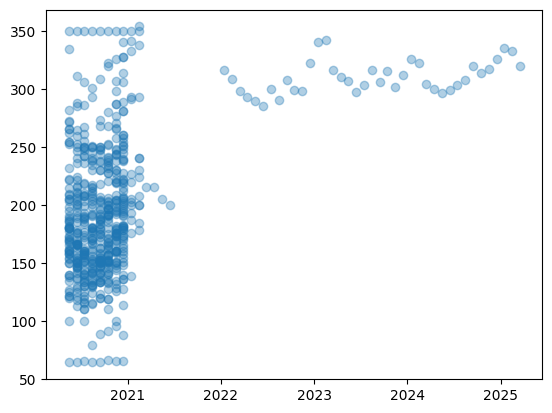

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2020-05-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [20]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

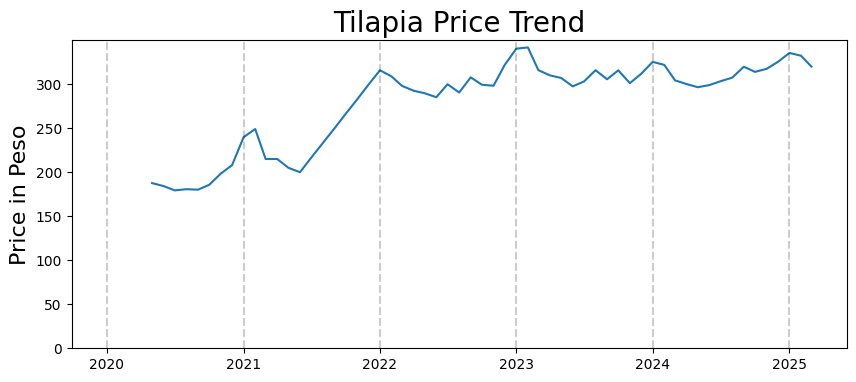

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = lim_tilapia.diff()[1:]

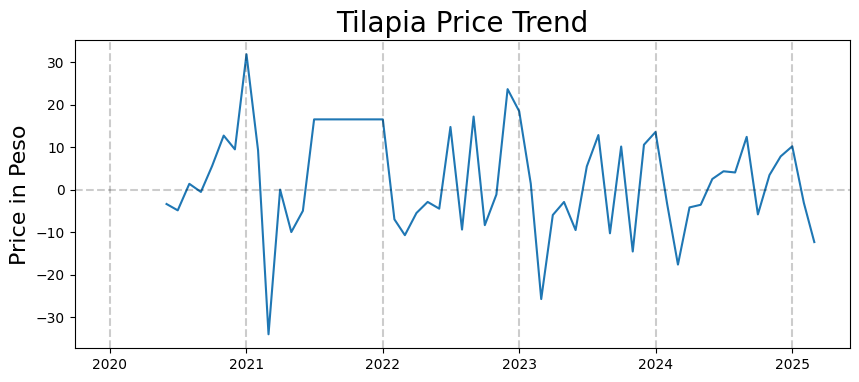

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [24]:
from statsmodels.tsa.stattools import acf, pacf

In [25]:
first_diff.columns

Index(['mp_price'], dtype='object')

<BarContainer object of 18 artists>

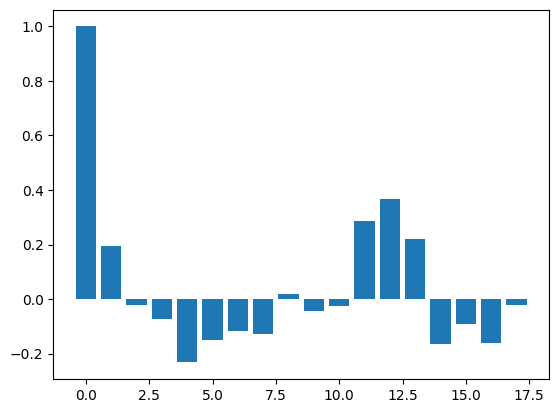

In [33]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

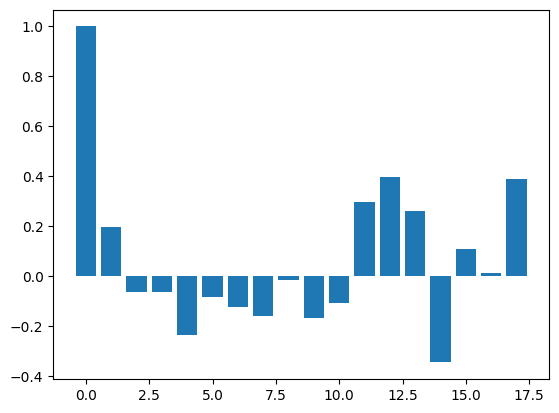

In [35]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [36]:
from datetime import timedelta

In [38]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [39]:
Tilapia.describe()

,mp_price
count,59.000000
mean,279.181472
std,49.451453
min,179.341908
25%,244.447950
50%,299.380000
75%,314.865000
max,341.760000


## Fit the SARIMA Model

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [41]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [42]:
from time import time

In [43]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72323D+00    |proj g|=  1.06887D+00

At iterate    5    f=  3.74901D+00    |proj g|=  1.05593D-02

At iterate   10    f=  3.74463D+00    |proj g|=  3.50908D-03

At iterate   15    f=  3.74232D+00    |proj g|=  1.98170D-02

At iterate   20    f=  3.73962D+00    |proj g|=  6.32592D-03

At iterate   25    f=  3.73900D+00    |proj g|=  2.62214D-03

At iterate   30    f=  3.73880D+00    |proj g|=  3.89891D-04


 This problem is unconstrained.


  ys=-9.635E-05  -gs= 2.447E-05 BFGS update SKIPPED

At iterate   35    f=  3.73875D+00    |proj g|=  1.46912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     69      2     1     0   6.534D-06   3.739D+00
  F =   3.7387525044041063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fitting Time: 0.42180562019348145



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [44]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -198.154
Date:                              Tue, 20 May 2025   AIC                            402.308
Time:                                      10:58:29   BIC                            408.161
Sample:                                  05-01-2020   HQIC                           404.552
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9993      0.116      8.646      0.000       0.773       1.226
ma.S.L12      -0.96

In [45]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    314.00
2024-11-01    317.43
2024-12-01    325.26
2025-01-01    335.47
2025-02-01    332.36


In [46]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [47]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [48]:
predictions

date
2024-10-01    324.751675
2024-11-01    327.495018
2024-12-01    339.895852
2025-01-01    356.431296
2025-02-01    356.489099
2025-03-01    338.344489
Freq: MS, Name: predicted_mean, dtype: float64

In [49]:
residuals

date
2024-10-01   -10.751675
2024-11-01   -10.065018
2024-12-01   -14.635852
2025-01-01   -20.961296
2025-02-01   -24.129099
2025-03-01   -18.344489
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

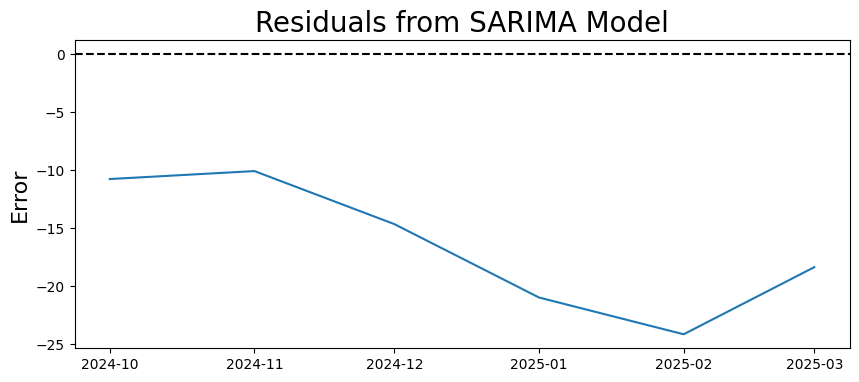

In [50]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

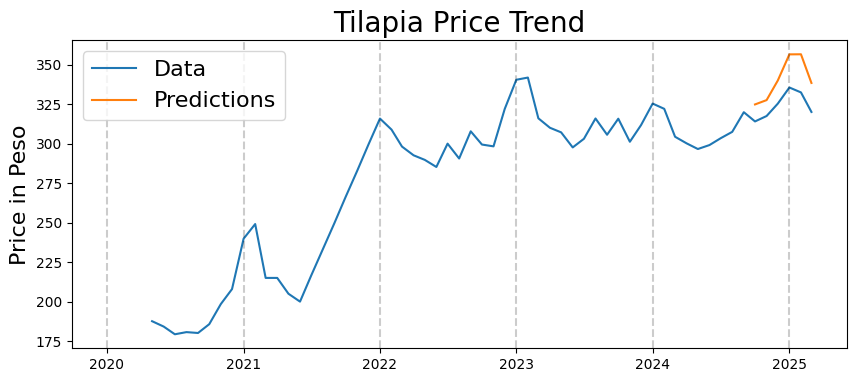

In [51]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [52]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72323D+00    |proj g|=  1.06887D+00

At iterate    5    f=  3.74901D+00    |proj g|=  1.05593D-02

At iterate   10    f=  3.74463D+00    |proj g|=  3.50908D-03

At iterate   15    f=  3.74232D+00    |proj g|=  1.98170D-02

At iterate   20    f=  3.73962D+00    |proj g|=  6.32592D-03


 This problem is unconstrained.



At iterate   25    f=  3.73900D+00    |proj g|=  2.62214D-03

At iterate   30    f=  3.73880D+00    |proj g|=  3.89891D-04
  ys=-9.635E-05  -gs= 2.447E-05 BFGS update SKIPPED

At iterate   35    f=  3.73875D+00    |proj g|=  1.46912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     69      2     1     0   6.534D-06   3.739D+00
  F =   3.7387525044041063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  3.76136D+00    |proj g|=  7.84971D-02

At iterate   10    f=  3.75131D+00    |proj g|=  8.97177D-03

At iterate   15    f=  3.74260D+00    |proj g|=  3.59914D-03

At iterate   20    f=  3.74058D+00    |proj g|=  3.16095D-03

At iterate   25    f=  3.74009D+00    |proj g|=  1.74857D-03

At iterate   30    f=  3.73996D+00    |proj g|=  5.96725D-04
  ys=-1.044E-05  -gs= 2.529E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     58      1     1     0   1.209D-03   3.740D+00
  F =   3.7399278220964516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     54      1     0     0   2.081D-04   3.730D+00
  F =   3.7301088606271717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11631D+00    |proj g|=  9.66082D-01

At iterate    5    f=  3.74775D+00    |proj g|=  8.70569D-02

At iterate   10    f=  3.73504D+00    |proj g|=  8.86075D-03

At iterate   15    f=  3.72530D+00    |proj g|=  6.01198D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   30    f=  3.72239D+00    |proj g|=  3.89739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     52      1     0     0   1.485D-04   3.722D+00
  F =   3.7223842338963991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03566D+00    |proj g|=  8.26644D-01

At iterate    5    f=  3.73855D+00    |proj g|=  7.77965D-02

At iterate   10    f=  3.72515D+00    |proj g|=  1.14348D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   20    f=  3.71701D+00    |proj g|=  3.77239D-03

At iterate   25    f=  3.71664D+00    |proj g|=  1.04423D-03

At iterate   30    f=  3.71656D+00    |proj g|=  2.05546D-04

At iterate   35    f=  3.71655D+00    |proj g|=  5.19434D-05

At iterate   40    f=  3.71653D+00    |proj g|=  5.06595D-04
  ys=-1.134E-04  -gs= 1.380E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     42     73      1     1     0   1.263D-03   3.717D+00
  F =   3.7165289107133268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   25    f=  3.70828D+00    |proj g|=  2.56741D-03

At iterate   30    f=  3.70822D+00    |proj g|=  2.00137D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     49      1     0     0   5.971D-04   3.708D+00
  F =   3.7082123147255839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_169172/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [53]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

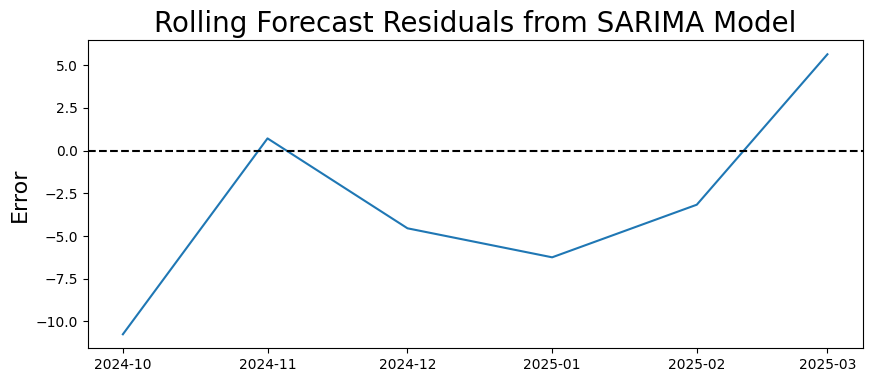

In [54]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

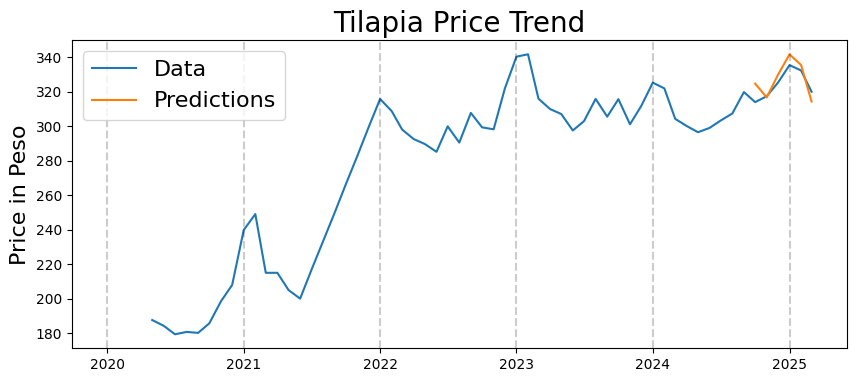

In [55]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [56]:
import numpy as np

In [57]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.016


In [58]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 6.022656716158326


## Future Predictions (2025)